# ROC

This code demonstrates how to use ROC curves to select an optimal classification threshold using a synthetic dataset. Here's what the code does:

1. **Data Preparation and Model Training**
   - Creates a synthetic binary classification dataset
   - Trains a Random Forest classifier
   - Calculates prediction probabilities for test data

2. **ROC Curve Analysis**
   - Generates the ROC curve (True Positive Rate vs False Positive Rate)
   - Calculates Area Under Curve (AUC)

3. **Threshold Selection Methods**
   - Implements two common methods for finding optimal thresholds:
     - **Youden's J statistic**: Maximizes (Sensitivity + Specificity - 1)
     - **Closest point to (0,1)**: Minimizes distance to the perfect classifier point

4. **Performance Evaluation**
   - Compares model performance at different thresholds
   - Calculates key metrics (accuracy, precision, recall, F1 score)
   - Visualizes confusion matrices for different thresholds

5. **Visualization**
   - Plots ROC curve with optimal threshold points
   - Shows how different performance metrics change with threshold values
   - Displays confusion matrices for selected thresholds

When you run this code, you'll see:
- How changing the threshold affects the balance between true positives and false positives
- Which threshold maximizes different performance metrics
- How different optimal threshold selection criteria compare


Comparison of Thresholds:
--------------------------------------------------
Default (0.5):
  threshold: 0.5000
  accuracy: 0.9167
  precision: 0.8662
  recall: 0.9714
  specificity: 0.8688
  f1_score: 0.9158

Youden's J (0.5300):
  threshold: 0.5300
  accuracy: 0.9267
  precision: 0.8986
  recall: 0.9500
  specificity: 0.9062
  f1_score: 0.9236

Closest to (0,1) (0.5500):
  threshold: 0.5500
  accuracy: 0.9267
  precision: 0.9097
  recall: 0.9357
  specificity: 0.9187
  f1_score: 0.9225


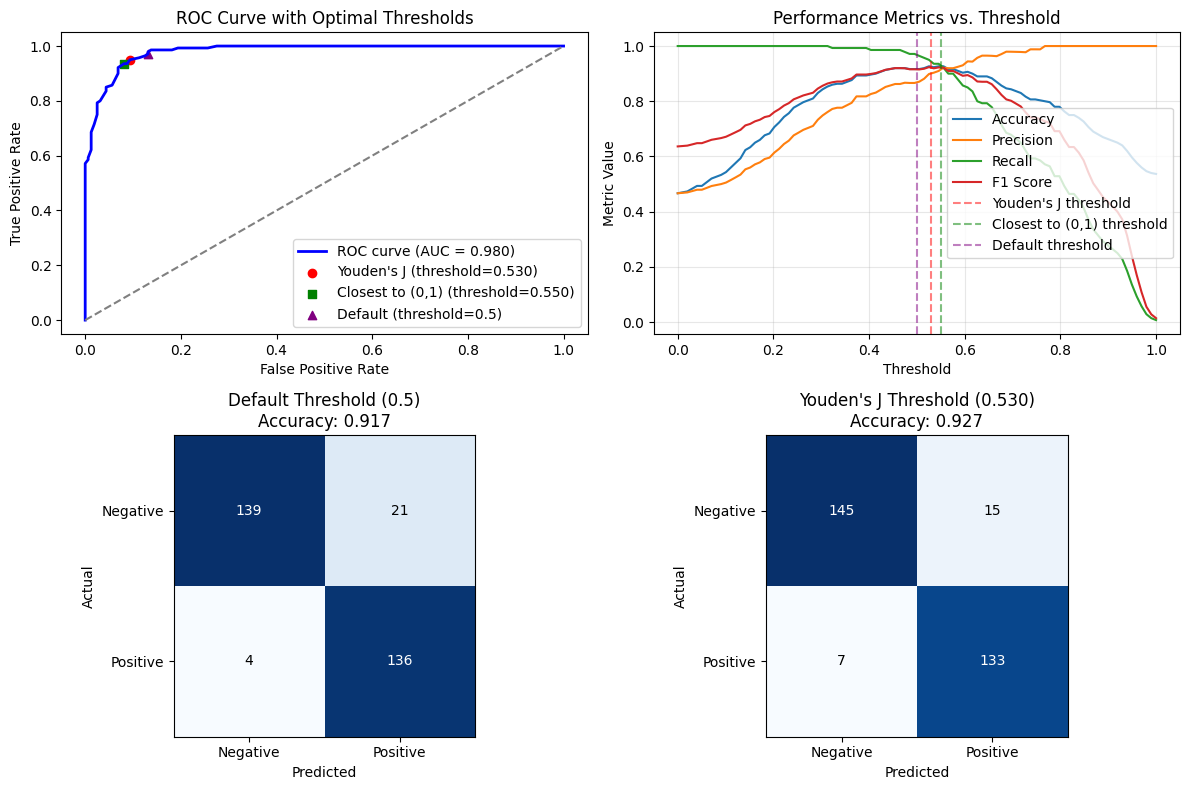

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set random seed for reproducibility
np.random.seed(42)

# Generate a synthetic binary classification dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                          n_redundant=5, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Get probability scores for the positive class
y_scores = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Calculate AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Function to find the optimal threshold based on different criteria
def find_optimal_threshold(fpr, tpr, thresholds):
    """
    Find the optimal threshold using different methods:
    1. Youden's J statistic (maximizes TPR - FPR)
    2. Closest point to (0,1)
    3. Balanced accuracy
    """
    # Youden's J statistic (maximizing TPR - FPR)
    j_scores = tpr - fpr
    j_optimal_idx = np.argmax(j_scores)
    j_optimal_threshold = thresholds[j_optimal_idx]

    # Point closest to (0,1) in the ROC space
    distances = np.sqrt((1-tpr)**2 + fpr**2)
    closest_optimal_idx = np.argmin(distances)
    closest_optimal_threshold = thresholds[closest_optimal_idx]

    return {
        "youden": (j_optimal_threshold, j_optimal_idx),
        "closest": (closest_optimal_threshold, closest_optimal_idx)
    }

# Find optimal thresholds
optimal_thresholds = find_optimal_threshold(fpr, tpr, thresholds)

# Evaluate model at different thresholds
def evaluate_threshold(y_true, y_scores, threshold):
    """Evaluate model performance at a given threshold"""
    y_pred = (y_scores >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    return {
        "threshold": threshold,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "specificity": specificity,
        "f1_score": f1,
        "confusion_matrix": {
            "TP": tp, "FP": fp,
            "TN": tn, "FN": fn
        }
    }

# Evaluate different thresholds
default_results = evaluate_threshold(y_test, y_scores, 0.5)
youden_results = evaluate_threshold(y_test, y_scores, optimal_thresholds["youden"][0])
closest_results = evaluate_threshold(y_test, y_scores, optimal_thresholds["closest"][0])

# Visualize ROC curve and optimal thresholds
plt.figure(figsize=(12, 8))

# Plot ROC curve
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Mark optimal points
youden_idx = optimal_thresholds["youden"][1]
closest_idx = optimal_thresholds["closest"][1]

plt.scatter(fpr[youden_idx], tpr[youden_idx], marker='o', color='red',
           label=f"Youden's J (threshold={optimal_thresholds['youden'][0]:.3f})")
plt.scatter(fpr[closest_idx], tpr[closest_idx], marker='s', color='green',
           label=f"Closest to (0,1) (threshold={optimal_thresholds['closest'][0]:.3f})")

# Default threshold of 0.5
default_idx = np.abs(thresholds - 0.5).argmin()
plt.scatter(fpr[default_idx], tpr[default_idx], marker='^', color='purple',
           label=f"Default (threshold=0.5)")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Optimal Thresholds')
plt.legend(loc="lower right")

# Plot threshold vs various metrics
plt.subplot(2, 2, 2)
metrics_at_thresholds = []
sampled_thresholds = np.linspace(0, 1, 100)
for threshold in sampled_thresholds:
    metrics = evaluate_threshold(y_test, y_scores, threshold)
    metrics_at_thresholds.append(metrics)

# Extract metrics for plotting
accuracies = [m["accuracy"] for m in metrics_at_thresholds]
precisions = [m["precision"] for m in metrics_at_thresholds]
recalls = [m["recall"] for m in metrics_at_thresholds]
f1_scores = [m["f1_score"] for m in metrics_at_thresholds]

plt.plot(sampled_thresholds, accuracies, label='Accuracy')
plt.plot(sampled_thresholds, precisions, label='Precision')
plt.plot(sampled_thresholds, recalls, label='Recall')
plt.plot(sampled_thresholds, f1_scores, label='F1 Score')

# Mark optimal thresholds
plt.axvline(x=optimal_thresholds["youden"][0], color='red', linestyle='--', alpha=0.5,
            label="Youden's J threshold")
plt.axvline(x=optimal_thresholds["closest"][0], color='green', linestyle='--', alpha=0.5,
            label="Closest to (0,1) threshold")
plt.axvline(x=0.5, color='purple', linestyle='--', alpha=0.5, label="Default threshold")

plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs. Threshold')
plt.legend(loc="center right")
plt.grid(True, alpha=0.3)

# Plot the confusion matrices for different thresholds
def plot_confusion_matrix(ax, results, title):
    cm = np.array([
        [results["confusion_matrix"]["TN"], results["confusion_matrix"]["FP"]],
        [results["confusion_matrix"]["FN"], results["confusion_matrix"]["TP"]]
    ])
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_yticklabels(['Negative', 'Positive'])

    # Add text annotations
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")

    return im

# Plot confusion matrices for each threshold
plt.subplot(2, 2, 3)
plot_confusion_matrix(plt.gca(), default_results, f"Default Threshold (0.5)\nAccuracy: {default_results['accuracy']:.3f}")

plt.subplot(2, 2, 4)
plot_confusion_matrix(plt.gca(), youden_results, f"Youden's J Threshold ({optimal_thresholds['youden'][0]:.3f})\nAccuracy: {youden_results['accuracy']:.3f}")

plt.tight_layout()

# Print summary of results
print("Comparison of Thresholds:")
print("-" * 50)
print(f"Default (0.5):")
for k, v in default_results.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v:.4f}")

print(f"\nYouden's J ({optimal_thresholds['youden'][0]:.4f}):")
for k, v in youden_results.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v:.4f}")

print(f"\nClosest to (0,1) ({optimal_thresholds['closest'][0]:.4f}):")
for k, v in closest_results.items():
    if k != "confusion_matrix":
        print(f"  {k}: {v:.4f}")

# Show the plots
plt.show()